In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import re

# Data Cleaning

##### remove upper_case (df_series_analysis)
#### drop tokens_raw

In [2]:
df_tbbt = pickle.load(open('df_tbbt', 'rb'))
df_tbbt.reset_index(drop=True, inplace=True)

In [3]:
%store -r df_nation
%store -r df_series_groups

In [4]:
#df_nation grouped by level_frequency 
# 0 -> 26 (proper_names) , 27 (marginal_words), 28 (compounds), 29 (acronyms)
# (5-25) -> levels from 5 to 15
#df_nation grouped by levels_coverage
# 15 -> (15: list between 15 and 25)

# df_nation.groupby('levels').count()
# df_nation.groupby('levels_frequency').count()
df_nation.groupby('levels_coverage').count() 
df_nation.sort_values('all_forms')

,base_forms,all_forms,levels,levels_frequency,levels_coverage
56173,a,a,1,1,1
1149,a1,a1,26,0,26
1150,a11,a11,26,0,26
1151,a168,a168,26,0,26
1152,a19,a19,26,0,26
...,...,...,...,...,...
30895,emigre,émigrés,12,5-25,12
69601,esprit,ésprit,16,5-25,15
89976,etoile,étoile,20,5-25,15
52372,etudes,étude,15,5-25,15


### Cleaning non-English letters

In [5]:
#'ν' --> 'v'
df_tbbt['transcripts'] = df_tbbt['transcripts'].apply(lambda x:re.sub('ν', 'v', x))
# 'l'--> i e.g. lmp (imposible) -> There's a problem coming from the source of the transcripts itself
# all i in upper case are treated as l (l in lower case) Fortunately most of them are pronouns like 'I' , but some words starting with 'i' in upper case are lost (small %)

In [6]:
df_tbbt['raw_tokens'] = df_tbbt['transcripts'].apply(lambda x:len(x.split()))

In [7]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_tbbt['raw_tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_tbbt['raw_tokens'].max()))

Min Raw: 1883
Max Raw: 5459


In [220]:
#first boxplot
# import plotly_express as px
# import plotly.graph_objects as go
# from plotly.offline import iplot, init_notebook_mode

# fig = go.Figure()
# fig.add_box(x=df_tbbt['raw_tokens'], text=df_tbbt.index)
# iplot(fig)
# sns.boxplot(x=df_tbbt['raw_tokens'])

In [9]:
#dropping corrupted transcripts
df_tbbt.drop([26, 35, 115, 153, 276], inplace=True)
df_tbbt.reset_index(drop=True, inplace=True)

In [10]:
# cleaning transcripts
#keep in mind that some transcripts contain comma with no space like 'hi,how are you' or " instead of ' like 'you"re'. after cleaning they, the trancsripts become useless
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_tbbt['transcripts'] = df_tbbt['transcripts'].apply(round1)

In [11]:
# df_series_clean_except_transcripts.groupby('series_titles').count()
df_tbbt = df_tbbt.assign(tokens=df_tbbt['transcripts'].apply(lambda x:len(x.split())))

In [12]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_tbbt['raw_tokens'].min()) + ', Min Clean: '+ str(df_tbbt['tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_tbbt['raw_tokens'].max()) + ', Max Clean: '+ str(df_tbbt['tokens'].max()))

Min Raw: 2116, Min Clean: 2165
Max Raw: 3194, Max Clean: 3285


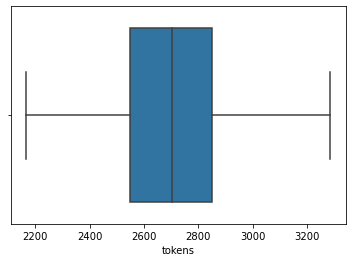

In [13]:
sns.boxplot(x=df_tbbt['tokens'])

### Episodes with less dialogues (less words to worry about)

In [218]:
df_tbbt.sort_values('raw_tokens')[:5]

,transcripts,series_titles,years,seasons,season_episodes,season_episode_names,tokens_raw,groups,tconst,upper_case,raw_tokens,tokens
52,whatcha doing i am attempting to view my work ...,the big bang theory,2007,3,14,S3E14: The Einstein Approximation,2116,group2,tt0898266,0,2116,2214
99,hello i am dr sheldon cooper and welcome to th...,the big bang theory,2007,5,14,S5E14: The Beta Test Initiation,2137,group2,tt0898266,1,2137,2183
72,water demon ice dragon lesser warlord of kaa n...,the big bang theory,2007,4,11,S4E11: The Justice League Recombination,2147,group2,tt0898266,2,2147,2165
41,good morning come dance with me poswhy not whi...,the big bang theory,2007,3,3,S3E3: The Gothowitz Deviation,2165,group2,tt0898266,0,2165,2259
87,what are you doing oh uh priya s calling in a ...,the big bang theory,2007,5,2,S5E2: The Infestation Hypothesis,2180,group2,tt0898266,0,2180,2280


# Exploratory Data Analysis

### Document-Term Matrix¶

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix = cv.fit_transform(df_tbbt['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_tbbt.index,
                                           columns=cv.get_feature_names())

In [16]:
df_dtm = df_dtm.T

# Formula

In [17]:
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms', indicator=True)
        df_count_words_level.loc[df_count_words_level['_merge']=='left_only', 'levels_coverage'] = 100
        if thousand_level is not None: #only consider words in specific levels
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level

In [18]:
def get_coverage(indices, df_dtm):
    frames = []
    for episode_index in indices:
        df_coverage_episode = get_frames([episode_index], df_dtm) ##
        df_coverage_episode = df_coverage_episode[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
        df_coverage_episode.drop([28, 29], axis=0, inplace=True, errors='ignore')
        df_coverage_episode['%'] = 100 * (round(df_coverage_episode['count']/
                                            df_coverage_episode['count'].sum(), 4))
        df_coverage_episode = df_coverage_episode.reset_index()
        condition = [(df_coverage_episode['levels_coverage']<=4),
            (df_coverage_episode['levels_coverage']>=5) & (df_coverage_episode['levels_coverage']<=15),
                    (df_coverage_episode['levels_coverage']>=26)] #15 includes list from 15 to 25
        values = [df_coverage_episode['levels_coverage'], 5, df_coverage_episode['levels_coverage']]
        df_coverage_episode['lvl'] = np.select(condition, values)
        df_coverage_episode = df_coverage_episode.groupby('lvl').sum()
        df_coverage_episode['cumulative'] = df_coverage_episode['%'].cumsum()
        if len(indices)==1:   
            df_coverage_episode = df_coverage_episode[['count', '%']].T.reset_index(drop=True)
        elif len(indices)>1:
            df_coverage_episode = df_coverage_episode[['%']].T.reset_index(drop=True)
            df_coverage_episode['index'] = episode_index
        frames.append(df_coverage_episode)
    return frames

### Vocabulary coverage of a random episode

In [19]:
index = 57 #episode number is different from index!!!
series_name = 'The Big Bang Theory'
df_random_episode = get_coverage([index], df_dtm)[0]
df_random_episode.rename(columns={26:'Character names', 27:'Interjections', 
                                  100:series_name+" words"}, inplace=True)
df_random_episode.T.rename(columns={0:'count', 1:'%'})

,count,%
lvl,,
1.0,1902.0,85.02
2.0,107.0,4.78
3.0,55.0,2.46
4.0,18.0,0.80
5.0,59.0,2.63
Character names,63.0,2.82
Interjections,11.0,0.49
The Big Bang Theory words,22.0,0.98


### Unique words in the TV show

In [20]:
df_words_series = get_frames(df_tbbt.index.values, df_dtm)
df_words_series = df_words_series[['all_forms', 'count', 'levels_coverage']]
df_words_series = df_words_series[df_words_series['levels_coverage']==100]
df_words_series

#check .groupby sparse(int64)
list_words = list(df_words_series['all_forms'])
list_count = list(df_words_series['count'])

In [134]:
#words repeated in all episodes in list 100 (TV series own vocabulary, particular phrases)
df_words_series.sort_values('count',ascending=False)[:10][['words', 'count']]
#find where those words were spoken
# df_tbbt[df_tbbt['transcripts'].str.contains('bitcoin')]
# df_tbbt.loc[235, 'transcripts']

,words,count
1206,meemaw,29
2249,vader,23
462,darth,22
83,aquaman,22
171,bazinga,21
1880,siri,20
399,collider,18
1645,purell,15
2079,texting,15
712,gablehauser,15


### Wordcloud

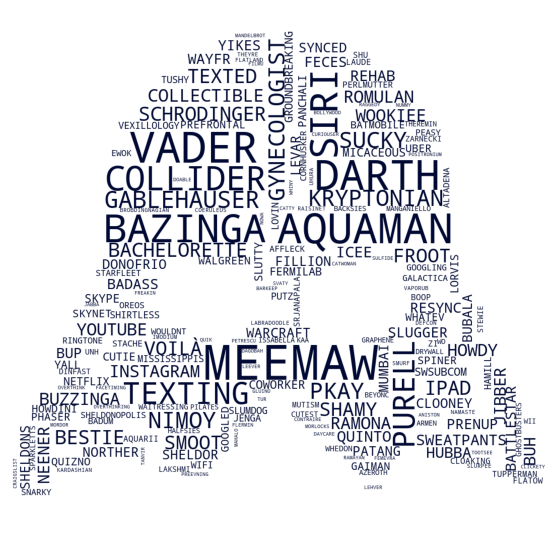

In [229]:
character_name = ['wolowitz', 'wheaton', 'priya', 'kripke', 'nowitzki', 'koothrappali', 'hofstadter',
                 'rajesh', 'lalita', 'siebert', 'anu', 'ruchi', 'rostenkowski']
# some transcripts have words such as You"re, don"t -> my cleaning.py doesn't sub ", but '
clean_words = ['youre', 'dont', 'didnt', 'youll', 'youve', 'shes', 'doesnt', 'sub', 'maam',
               'facebook', 'bitcoin','elderman', 'autotrophs', 'ew', 'grad', 'opensubtitlesorg']#sync corrected...., 'autotrophs' part of the song, grad student
character_name.extend(clean_words)

df_words_series = pd.DataFrame({'words':list_words, 'count':list_count})
df_words_series = df_words_series.groupby('words', as_index=False).sum().sort_values('count', ascending=False)

# words only found in the series excluding character names
df_words_series = df_words_series[~df_words_series['words'].isin(character_name)]
df_words_series['words'] = df_words_series['words'].apply(lambda x:x+' ')
df_words_series['text'] = df_words_series['words']*df_words_series['count']
words = ''.join(df_words_series['text'])


from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
shape = np.array(Image.open('darth_vader.png'))
wc = WordCloud(background_color = 'white', mask=shape, collocations=False, width=300, height=130) #600,300
wc.generate(words.upper())


def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(10,11))

image_colors = ImageColorGenerator(shape)
wc.recolor(color_func=grey_color_func)
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()
wc.to_file("wordcloud.png")

### Vocabulary coverage of the average GoT episode - Should I watch Friends, The Simpsons or GoT?

In [26]:
frames = get_coverage(df_tbbt.index.values, df_dtm)

In [27]:
pd.concat(frames, axis=0, ignore_index=True)[[1, 2, 3, 4, 5, 26, 27, 100]].mean()

1.0      85.059780
2.0       4.412051
3.0       1.723333
4.0       1.063333
5.0       3.082784
26.0      2.330440
27.0      1.426912
100.0     0.908755
dtype: float64

### Vocabulary coverage in all episodes

In [207]:
df_statistics = pd.concat(frames, axis=0, ignore_index=True)[['index', 1, 2, 3, 4, 5, 26, 27, 100]]
df_statistics = df_statistics.fillna(0)
#assume you know interjections, character names and words created in the tv series
df_statistics['Lvl 1'] = df_statistics[1] + df_statistics[26] + df_statistics[27] + df_statistics[100]
df_statistics['Lvl 1+2'] = df_statistics['Lvl 1'] + df_statistics[2]
df_statistics['Lvl 1+2+3'] = df_statistics['Lvl 1+2'] + df_statistics[3]
df_statistics['Lvl 1+2+3+4'] = df_statistics['Lvl 1+2+3'] + df_statistics[4]
df_statistics = pd.concat((df_statistics.set_index('index'), df_tbbt[['season_episode_names', 'seasons']]), axis=1)
df_statistics

,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4,season_episode_names,seasons
0,84.03,4.30,2.81,1.21,4.75,1.32,0.82,0.75,86.92,91.22,94.03,95.24,S1E0: Unaired Pilot,1
1,83.54,5.20,2.36,0.92,3.75,2.29,1.25,0.66,87.74,92.94,95.30,96.22,S1E1: Pilot,1
2,82.88,6.28,2.95,1.18,3.47,1.60,1.10,0.55,86.13,92.41,95.36,96.54,S1E2: The Big Bran Hypothesis,1
3,82.08,4.61,2.89,1.52,4.00,2.09,2.25,0.56,86.98,91.59,94.48,96.00,S1E3: The Fuzzy Boots Corollary,1
4,84.65,5.05,2.06,1.09,3.16,1.64,1.51,0.84,88.64,93.69,95.75,96.84,S1E4: The Luminous Fish Effect,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,86.17,3.68,2.03,1.07,2.92,1.99,1.46,0.69,90.31,93.99,96.02,97.09,S12E19: The Inspiration Deprivation,12
269,87.58,3.76,1.77,0.71,1.92,1.56,1.56,1.14,91.84,95.60,97.37,98.08,S12E20: Episode #12.20,12
270,88.11,3.57,1.44,1.17,1.96,2.20,1.00,0.55,91.86,95.43,96.87,98.04,S12E21: The Plagiarism Schism,12
271,89.67,3.57,1.28,0.39,1.57,1.67,1.44,0.43,93.21,96.78,98.06,98.45,S12E22: Episode #12.22,12


#### Filtering more episodes out (with list 100)

In [208]:
#rule of thum % in list 100 <3.5
#most of the words in list 100 of the episode S12E3 are 'you"re' or 'don"t' so it's fine to consider them in LVL1
df_statistics.sort_values(100, ascending=False)[:10]

,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4,season_episode_names,seasons
253,87.67,2.62,0.87,0.64,2.67,1.35,0.32,3.86,93.20,95.82,96.69,97.33,S12E3: The Procreation Calculation,12
95,79.67,4.46,1.85,1.26,4.75,3.97,1.35,2.71,87.70,92.16,94.01,95.27,S5E10: The Flaming Spittoon Acquisition,5
28,83.15,4.86,1.75,1.75,3.63,2.14,0.18,2.54,88.01,92.87,94.62,96.37,S2E12: The Killer Robot Instability,2
8,84.95,4.25,1.37,0.94,3.21,2.22,0.59,2.50,90.26,94.51,95.88,96.82,S1E8: The Grasshopper Experiment,1
35,82.70,4.14,1.94,2.11,4.20,2.46,0.17,2.29,87.62,91.76,93.70,95.81,S2E20: The Hofstadter Isotope,2
41,83.27,4.43,2.29,1.26,4.05,2.19,0.34,2.19,87.99,92.42,94.71,95.97,S3E3: The Gothowitz Deviation,3
80,83.01,4.81,1.26,1.26,3.84,2.66,1.10,2.07,88.84,93.65,94.91,96.17,S4E19: The Zarnecki Incursion,4
68,78.93,6.64,2.13,1.39,4.38,3.57,0.98,1.97,85.45,92.09,94.22,95.61,S4E7: The Apology Insufficiency,4
246,86.68,3.03,1.65,0.59,2.02,2.24,1.85,1.96,92.73,95.76,97.41,98.00,S11E20: The Reclusive Potential,11
33,80.57,6.49,2.22,1.60,3.41,3.03,0.80,1.90,86.30,92.79,95.01,96.61,S2E17: The Terminator Decoupling,2


### Top 10 GoT episodes (easies vocabulary)

In [209]:
for i in df_statistics.sort_values(['Lvl 1'], ascending=False)[:10].values:
    print(i[12])

S9E2: The Separation Oscillation
S12E4: The Tam Turbulence
S11E14: The Separation Triangulation
S9E1: The Matrimonial Momentum
S7E24: The Status Quo Combustion
S11E23: The Sibling Realignment
S12E22: Episode #12.22
S12E3: The Procreation Calculation
S12E15: Episode #12.15
S7E11: The Cooper Extraction


### ScatterPlot

In [210]:
#preparing data
df_statistics = df_statistics.sort_values('Lvl 1', ascending=False)
df_1 = df_statistics[['Lvl 1', 'season_episode_names']]
df_1 = df_1.assign(label = 'Lvl 1')
df_1.rename(columns={'Lvl 1':'lvl'}, inplace=True)
df_2 = df_statistics[['Lvl 1+2', 'season_episode_names']]
df_2 = df_2.assign(label = 'Lvl 1+2')
df_2.rename(columns={'Lvl 1+2':'lvl'}, inplace=True)
df_3 = df_statistics[['Lvl 1+2+3', 'season_episode_names']]
df_3 = df_3.assign(label = 'Lvl 1+2+3')
df_3.rename(columns={'Lvl 1+2+3':'lvl'}, inplace=True)
# df_4 = df_statistics[['Lvl 1+2+3+4', 'season_episode_names']]
# df_4 = df_4.assign(label = 'Lvl 1+2+3+4')
# df_4.rename(columns={'Lvl 1+2+3+4':'lvl'}, inplace=True)
df_dot = pd.concat([df_1, df_2, df_3])
df_dot['lvl'] = df_dot['lvl'].apply(lambda x:round(x,1))
df_dot.reset_index(drop=True, inplace=True)

In [211]:
#adding ranking column
rank = df_dot.index.values
df_dot['rank'] = rank+1
df_dot.loc[df_dot['rank']>len(df_statistics), 'rank']='-'
df_dot

,lvl,season_episode_names,label,rank
0,93.8,S9E2: The Separation Oscillation,Lvl 1,1
1,93.6,S12E4: The Tam Turbulence,Lvl 1,2
2,93.6,S11E14: The Separation Triangulation,Lvl 1,3
3,93.5,S9E1: The Matrimonial Momentum,Lvl 1,4
4,93.4,S7E24: The Status Quo Combustion,Lvl 1,5
...,...,...,...,...
814,93.2,S4E10: The Alien Parasite Hypothesis,Lvl 1+2+3,-
815,93.0,S4E2: The Cruciferous Vegetable Amplification,Lvl 1+2+3,-
816,92.8,S3E8: The Adhesive Duck Deficiency,Lvl 1+2+3,-
817,93.7,S4E21: The Agreement Dissection,Lvl 1+2+3,-


In [212]:
episode_count = []

for index, percentage in enumerate(df_dot['lvl']):
    subset = df_dot.iloc[:index+1]    # Create subset starting at the beginning of dataset until the episode
    count = len(subset[subset['lvl'] == percentage])   # Count all episode with same % in this subset
    episode_count.append(count)
    
df_dot['count'] = episode_count

In [213]:
df_dot['season_episode_names'] = df_dot['season_episode_names'].apply(lambda x:re.sub(',', '', x))

In [222]:
# data for DataWrapper
# for i in df_dot.values:
#     print(i[1] + ' , ' + i[2] + ' , ' + str(i[3]) + ' , ' + str(i[4]) + ' , ' + str(i[0]))

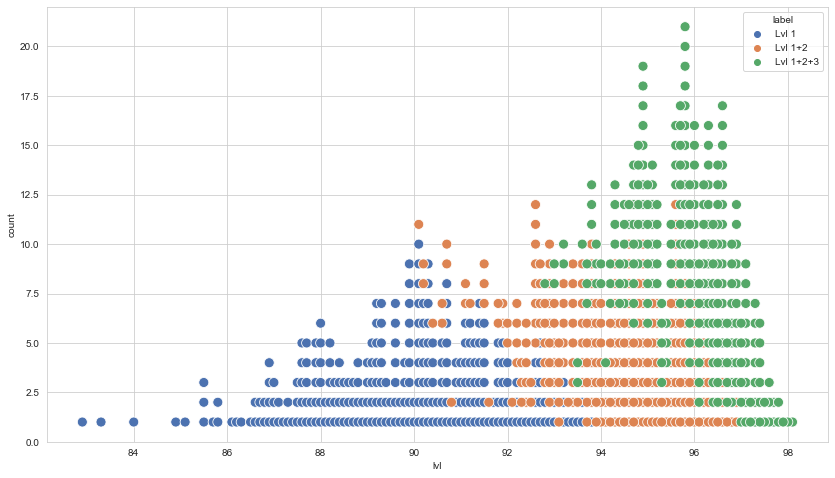

In [186]:
#Static plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='lvl', y='count', data=df_dot,
             hue='label', s=100, ax=ax, palette="deep")

## Interactive plot
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

# fig = go.Figure()
# for genre, df_genre in df_dot.groupby('label'):
#     fig.add_scatter(x=df_genre["lvl"], y=df_genre['count'], text=df_genre['season_episode_names'],
#     name=genre, mode='markers')
# iplot(fig)

### What hard words are they saying across all GoT episodes?

In [145]:
frames_2 = []
for episode_index in df_tbbt.index.values:
    df_vocabulary_episode = get_frames([episode_index], df_dtm, ['3', '4', '5-25'])
    df_vocabulary_episode['index'] = episode_index
    frames_2.append(df_vocabulary_episode)

In [146]:
df_tbbt_lvl = pd.concat(frames_2)
df_tbbt_lvl = pd.merge(df_tbbt_lvl, df_tbbt[['season_episode_names']].reset_index(), on='index')
df_tbbt_lvl = df_tbbt_lvl[['all_forms', 'count', 'base_forms', 'levels_frequency', 'season_episode_names']]
df_tbbt_lvl['season_episode_names'] = df_tbbt_lvl['season_episode_names'].apply(lambda x:re.sub(',', '', x))
df_tbbt_lvl
# df_tbbt_lvl[df_tbbt_lvl['levels_coverage']>=15]

,all_forms,count,base_forms,levels_frequency,season_episode_names
0,adequate,1,adequate,3,S1E0: Unaired Pilot
1,aim,1,aim,3,S1E0: Unaired Pilot
2,ample,1,ample,5-25,S1E0: Unaired Pilot
3,anti,1,anti,5-25,S1E0: Unaired Pilot
4,apologize,1,apology,3,S1E0: Unaired Pilot
...,...,...,...,...,...
30750,vacation,1,vacation,5-25,S12E24: Episode #12.24
30751,vampire,2,vampire,5-25,S12E24: Episode #12.24
30752,viral,1,viral,5-25,S12E24: Episode #12.24
30753,whittle,1,whittle,5-25,S12E24: Episode #12.24


In [219]:
## data for Datawrapper
# for i in df_tbbt_lvl.values:
#     print(str(i[0])+', '+str(i[1])+', '+str(i[2])+', '+str(i[3])+', '+str(i[4]))